# Data exploration
This notebook provides an example how the data has been loaded and accessed for further analysis.

In [1]:
# Enable autoreloading of our modules. 
# Most of the code will be located in the /src/ folder, 
# and then called from the notebook.

%reload_ext autoreload
%autoreload

In [2]:
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import os

import plotly
import plotly.graph_objs as go
import plotly.plotly as py

from ipywidgets import widgets
from IPython.display import display, clear_output, Image

In [13]:
data_folder = '../data/interim'
df_waves = pd.read_csv(os.path.join(data_folder, 'waves.csv'), index_col=[0,1])
df_tides = pd.read_csv(os.path.join(data_folder, 'tides.csv'), index_col=[0,1])
df_profiles = pd.read_csv(os.path.join(data_folder, 'profiles.csv'), index_col=[0,1,2])
df_sites = pd.read_csv(os.path.join(data_folder, 'sites.csv'),index_col=[0])
df_profile_features = pd.read_csv(os.path.join(data_folder, 'profile_features.csv'),index_col=[0])

C:\Users\z5189959\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [18]:
###### Create widget to control which site we're viewing
textbox = widgets.Dropdown(
    description='site_id:   ',
    value='NARRA0001',
    options=df_profiles.index.get_level_values('site_id').unique().sort_values().tolist()
)
container = widgets.HBox(children=[textbox])


# Add panel for pre/post storm profiles
trace1 = go.Scatter(
    x = [0],
    y = [0],
    name='Pre Storm Profile'
)
trace2 = go.Scatter(
    x = [0],
    y = [0],
    name='Post Storm Profile'
)
trace3 = go.Scatter(
    x = [0],
    y = [0],
    name='Pre-storm dune crest',
    mode = 'markers',
    marker = dict(
          color = 'rgb(17, 157, 255)',
          size = 20,
        ),
)
trace4 = go.Scatter(
    x = [0],
    y = [0],
    name='Pre-storm dune toe',
    mode = 'markers',
        marker = dict(
          color = 'rgb(231, 99, 250)',
          size = 20,
         ),
)

layout = go.Layout(
    title = 'Bed Profiles',
    legend=dict(x=0, y=1),
    margin=dict(t=50,b=50,l=20,r=20),
    xaxis=dict(
        title = 'x (m)',
        autorange=True,
        showgrid=True,
        zeroline=True,
        showline=True,
        range=[0, 200]
    ),
    yaxis=dict(
        title = 'z (m)',
        autorange=False,
        showgrid=True,
        zeroline=True,
        showline=True,
        range=[-1, 20]
    )
)

g1 = go.FigureWidget(data=[trace1, trace2, trace3, trace4],
                    layout=layout)


# Add panel for google maps
mapbox_access_token = 'pk.eyJ1IjoiY2hyaXNsZWFtYW4iLCJhIjoiY2pvNTY1MzZpMDc2OTN2bmw5MGsycHp5bCJ9.U2dwFg2c7RFjUNSayERUiw'

data = [
    go.Scattermapbox(
        lat=df_sites['lat'],
        lon=df_sites['lon'],
        mode='markers',
        marker=dict(
            size=10
        ),
        text=df_sites.index.get_level_values('site_id'),
    ),
    go.Scattermapbox(
        lat=[0],
        lon=[0],
        mode='markers',
        marker=dict(
            size=20,
            color='rgb(255, 0, 0)',
            opacity = 0.5,
        ),
        text=df_sites.index.get_level_values('site_id'),
    ),
]

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    showlegend=False,
    margin=dict(t=50,b=50,l=20,r=20),
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=-33.7,
            lon=151.3
        ),
        pitch=0,
        zoom=12,
        style='satellite-streets'
    ),
)

fig = dict(data=data, layout=layout)

g2 = go.FigureWidget(data=data,
                    layout=layout)

def response(change):
    
    site_id = textbox.value
    site_profile = df_profiles.query('site_id == "{}"'.format(site_id))
    prestorm_profile = site_profile.query('profile_type == "prestorm"')
    poststorm_profile = site_profile.query('profile_type == "poststorm"')

    poststorm_x = poststorm_profile.index.get_level_values('x').tolist()
    poststorm_z = poststorm_profile.z.tolist()

    prestorm_x = prestorm_profile.index.get_level_values('x').tolist()
    prestorm_z = prestorm_profile.z.tolist()
    
    site_features = df_profile_features.query('site_id == "{}"'.format(site_id))
    dune_crest_x = site_features.dune_crest_x
    dune_crest_z = site_features.dune_crest_z
    dune_toe_x = site_features.dune_toe_x
    dune_toe_z = site_features.dune_toe_z
    
    with g1.batch_update():
        g1.data[0].x = prestorm_x
        g1.data[0].y = prestorm_z
        g1.data[1].x = poststorm_x
        g1.data[1].y = poststorm_z
        g1.data[2].x = dune_crest_x
        g1.data[2].y = dune_crest_z
        g1.data[3].x = dune_toe_x
        g1.data[3].y = dune_toe_z
        
    # Update 
    site_coords = df_sites.query('site_id == "{}"'.format(site_id))
    with g2.batch_update():
        g2.layout.mapbox['center'] = {
            'lat': site_coords['lat'].values[0],
            'lon': site_coords['lon'].values[0]
        }
        g2.layout.mapbox['zoom'] = 15
        g2.data[1].lat = [site_coords['lat'].values[0]]
        g2.data[1].lon = [site_coords['lon'].values[0]]
        g2.data[1].text = site_coords['lon'].index.get_level_values('site_id').tolist()
        
textbox.observe(response, names="value")
widgets.VBox([container,widgets.HBox([g1,g2])])

VBox(children=(HBox(children=(Dropdown(description='site_id:   ', index=943, options=('AVOCAn0001', 'AVOCAn0002', 'AVOCAn0003', 'AVOCAn0004', 'AVOCAn0005', 'AVOCAn0006', 'AVOCAn0007', 'AVOCAn0008', 'AVOCAn0009', 'AVOCAs0001', 'AVOCAs0002', 'AVOCAs0003', 'AVOCAs0004', 'AVOCAs0005', 'AVOCAs0006', 'AVOCAs0007', 'AVOCAs0008', 'BILG0001', 'BILG0002', 'BILG0003', 'BILG0004', 'BILG0005', 'BLUEYS0001', 'BLUEYS0002', 'BLUEYS0003', 'BLUEYS0004', 'BLUEYS0005', 'BLUEYS0006', 'BOAT0001', 'BOAT0002', 'BOAT0003', 'BOAT0004', 'BOAT0005', 'BOOM0001', 'BOOM0002', 'BOOM0003', 'BOOM0004', 'BOOM0005', 'BOOM0006', 'BOOM0007', 'BOOM0008', 'BOOM0009', 'BOOM0010', 'BOOM0011', 'BOOM0012', 'BOOM0013', 'BOOM0014', 'CATHIE0001', 'CATHIE0002', 'CATHIE0003', 'CATHIE0004', 'CATHIE0005', 'CATHIE0006', 'CATHIE0007', 'CATHIE0008', 'CATHIE0009', 'CATHIE0010', 'CATHIE0011', 'CATHIE0012', 'CATHIE0013', 'CATHIE0014', 'CATHIE0015', 'CATHIE0016', 'CATHIE0017', 'CATHIE0018', 'CATHIE0019', 'CATHIE0020', 'CATHIE0021', 'CATHIE0022', 'CATHIE0023', 'CATHIE0024', 'CATHIE0025', 'CATHIE0026', 'CATHIE0027', 'CATHIE0028', 'CATHIE0029', 'CRESn0001', 'CRESn0002', 'CRESn0003', 'CRESn0004', 'CRESn0005', 'CRESn0006', 'CRESn0007', 'CRESn0008', 'CRESn0009', 'CRESn0010', 'CRESn0011', 'CRESn0012', 'CRESn0013', 'CRESn0014', 'CRESn0015', 'CRESn0016', 'CRESn0017', 'CRESn0018', 'CRESn0019', 'CRESn0020', 'CRESn0021', 'CRESn0022', 'CRESn0023', 'CRESn0024', 'CRESn0025', 'CRESn0026', 'CRESn0027', 'CRESn0028', 'CRESn0029', 'CRESn0030', 'CRESn0031', 'CRESn0032', 'CRESn0033', 'CRESn0034', 'CRESn0035', 'CRESn0036', 'CRESn0037', 'CRESn0038', 'CRESn0039', 'CRESn0040', 'CRESn0041', 'CRESn0042', 'CRESn0043', 'CRESn0044', 'CRESn0045', 'CRESn0046', 'CRESn0047', 'CRESn0048', 'CRESn0049', 'CRESn0050', 'CRESn0051', 'CRESn0052', 'CRESn0053', 'CRESn0054', 'CRESn0055', 'CRESn0056', 'CRESn0057', 'CRESn0058', 'CRESn0059', 'CRESn0060', 'CRESn0061', 'CRESn0062', 'CRESn0063', 'CRESn0064', 'CRESn0065', 'CRESn0066', 'CRESn0067', 'CRESn0068', 'CRESn0069', 'CRESn0070', 'CRESn0071', 'CRESn0072', 'CRESn0073', 'CRESn0074', 'CRESn0075', 'CRESn0076', 'CRESn0077', 'CRESn0078', 'CRESn0079', 'CRESn0080', 'CRESn0081', 'CRESn0082', 'CRESn0083', 'CRESn0084', 'CRESn0085', 'CRESn0086', 'CRESn0087', 'CRESn0088', 'CRESn0089', 'CRESn0090', 'CRESn0091', 'CRESn0092', 'CRESn0093', 'CRESn0094', 'CRESn0095', 'CRESn0096', 'CRESn0097', 'CRESn0098', 'CRESn0099', 'CRESn0100', 'CRESn0101', 'CRESn0102', 'CRESn0103', 'CRESn0104', 'CRESn0105', 'CRESn0106', 'CRESn0107', 'CRESn0108', 'CRESn0109', 'CRESn0110', 'CRESn0111', 'CRESn0112', 'CRESn0113', 'CRESn0114', 'CRESn0115', 'CRESn0116', 'CRESn0117', 'CRESn0118', 'CRESn0119', 'CRESn0120', 'CRESn0121', 'CRESn0122', 'CRESn0123', 'CRESn0124', 'CRESn0125', 'CRESs0001', 'CRESs0002', 'CRESs0003', 'CRESs0004', 'CRESs0005', 'CRESs0006', 'CRESs0007', 'CRESs0008', 'CRESs0009', 'CRESs0010', 'CRESs0011', 'CRESs0012', 'CRESs0013', 'CRESs0014', 'DEEWHYn0001', 'DEEWHYn0002', 'DEEWHYn0003', 'DEEWHYn0004', 'DEEWHYn0005', 'DEEWHYn0006', 'DEEWHYn0007', 'DEEWHYn0008', 'DEEWHYn0009', 'DEEWHYn0010', 'DEEWHYn0011', 'DEEWHYn0012', 'DEEWHYs0001', 'DEEWHYs0002', 'DEEWHYs0003', 'DEEWHYs0004', 'DEEWHYs0005', 'DEEWHYs0006', 'DEEWHYs0007', 'DEEWHYs0008', 'DIAMONDn0001', 'DIAMONDn0002', 'DIAMONDn0003', 'DIAMONDn0004', 'DIAMONDn0005', 'DIAMONDn0006', 'DIAMONDn0007', 'DIAMONDn0008', 'DIAMONDn0009', 'DIAMONDn0010', 'DIAMONDn0011', 'DIAMONDn0012', 'DIAMONDn0013', 'DIAMONDn0014', 'DIAMONDn0015', 'DIAMONDn0016', 'DIAMONDn0017', 'DIAMONDn0018', 'DIAMONDn0019', 'DIAMONDn0020', 'DIAMONDn0021', 'DIAMONDn0022', 'DIAMONDn0023', 'DIAMONDn0024', 'DIAMONDn0025', 'DIAMONDn0026', 'DIAMONDn0027', 'DIAMONDn0028', 'DIAMONDn0029', 'DIAMONDn0030', 'DIAMONDn0031', 'DIAMONDn0032', 'DIAMONDn0033', 'DIAMONDn0034', 'DIAMONDn0035', 'DIAMONDn0036', 'DIAMONDn0037', 'DIAMONDn0038', 'DIAMONDn0039', 'DIAMONDn0040', 'DIAMONDn0041', 'DIAMONDs0001', 'DIAMONDs0002', 'DIAMONDs0003', 'DIAMONDs0004', 'DIAMONDs0005', 'DIAMONDs0006', 'DIAMONDs0007', 'DUNBn0001', 'DUNBn0002

<IPython.core.display.Javascript object>


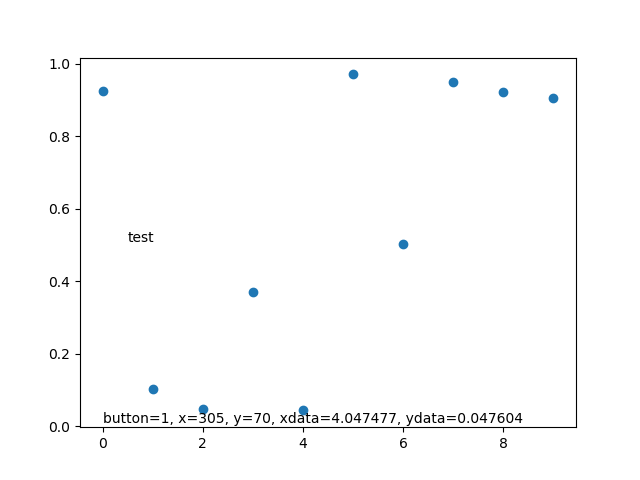

9

In [8]:

# Test of using matplotlib for manual point clicking
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10), 'o',picker=5)
text1=ax.text(0,0, "", va="bottom", ha="left")
text2=ax.text(0.5,0.5, "hello", va="bottom", ha="left")
temp = []
n=1

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text1.set_text(tx)
    temp.append(tx)
    
def press(event):
    if event.key == 'x':
        text2.set_text('test')

points = []
n = 5

def onpick(event):
    if len(points) < n:
        thisline = event.artist
        xdata = thisline.get_xdata()
        ydata = thisline.get_ydata()
        ind = event.ind
        point = tuple(zip(xdata[ind], ydata[ind]))
        points.append(point)
        print('onpick point:', point)
    else:
        print('already have {} points'.format(len(points)))
    return True

fig.canvas.mpl_connect('pick_event', onpick)

fig.canvas.mpl_connect('key_press_event',press)
fig.canvas.mpl_connect('button_press_event',onclick)


In [12]:
points

[((3.0, 0.3693345274194554),),
 ((6.0, 0.5016711151639491),),
 ((1.0, 0.10238977657533999),),
 ((2.0, 0.04706622152810236),),
 ((4.0, 0.04404424214020075),)]